In [1]:
# colab 환경에서 설치되지 않은 필수 패키지 설치
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.5MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 450kB 20.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


# 트레이닝 데이터 로드
- 원본 데이터로부터 문장부호를 제거하고 이를 새로운 문장으로 만들어서 test.nlp에 저장

In [2]:
import csv
from konlpy.tag import Okt
from gensim.models import word2vec
from collections import Counter
import matplotlib.pyplot as plt

# 해리포터 텍스트 파일 4개를 읽어서 합침
# Harry Potter 4의 경우 읽는데 문제가 있어서 해당 부분은 무시
harry_potter1 = open('''/content/drive/MyDrive/harry_potter/text/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt''').read()
harry_potter2 = open('''/content/drive/MyDrive/harry_potter/text/J. K. Rowling - Harry Potter 2 - The Chamber Of Secrets.txt''').read()
harry_potter3 = open('''/content/drive/MyDrive/harry_potter/text/J. K. Rowling - Harry Potter 3 - Prisoner of Azkaban.txt''').read()
harry_potter4 = open('''/content/drive/MyDrive/harry_potter/text/J. K. Rowling - Harry Potter 4 - The Goblet of Fire.txt''', errors='ignore').read()

harry_potter = harry_potter1 + harry_potter2 + harry_potter3 + harry_potter4

texts = harry_potter.splitlines();

twitter = Okt()

result = []
for line in texts:
    if len(line) > 0:
      #형태소 분석하기, 단어 기본형 사용
      malist = twitter.pos(line, norm=True, stem=True)
      r = []
      for word in malist:
          # 문장부호는 제외
          if not word[1] in ["Punctuation"]:
              r.append(word[0])
      #형태소 사이에 공백문자를 넣고 양쪽 공백을 지움으로써 하나의 문장을 구성
      rl = (" ".join(r)).strip()
      result.append(rl)
    # print(rl)

#형태소들을 별도의 파일로 저장 합니다.
with open("test.nlp",'w', encoding='utf-8') as fp:
    fp.write("\n".join(result))

# 단어분포 시각화
- wordcloud 사용
- twitter(Okt) 라이브러리 사용시 태그정보에 명사, 형용사 정보가 나오지 않고 문장부호만 구분 가능하여 문장부호만 제거하여 시각화
- 대명사, 조동사등을 제외하면 사람이름이 주로 나오는 것을 확인할 수 있음
- 테스트 문장 생성시 사람이름을 주로 사용하여 문장 생성을 진행해봄

[('\n', 22251), ('the', 20265), ('to', 11169), ('and', 10903), ('\n\n', 10576), ('of', 8753), ('a', 8693), ('Harry', 8102), ('was', 6795), ('he', 6601), ('said', 6060), ('s', 5928), ('his', 5898), ('I', 5324), ('in', 5243), ('it', 4843), ('you', 4602), ('had', 4108), ('t', 3830), ('that', 3687), ('at', 3633), ('on', 3102), ('him', 3045), ('Ron', 2921), ('as', 2900), ('He', 2722), ('with', 2633), ('they', 2323), ('for', 2181), ('Hermione', 2097), ('up', 2094), ('out', 2000), ('were', 1913), ('be', 1871), ('them', 1840), ('all', 1767), ('The', 1698), ('her', 1694), ('but', 1688), ('from', 1600), ('into', 1569), ('have', 1559), ('back', 1461), ('been', 1329), ('she', 1304), ('what', 1298), ('It', 1291), ('not', 1284), ('me', 1233), ('Hagrid', 1171), ('their', 1168), ('is', 1152), ('You', 1151), ('one', 1148), ('about', 1133), ('this', 1124), ('who', 1118), ('down', 1099), ('there', 1065), ('could', 1062), ('Dumbledore', 1059), ('Professor', 1051), ('looked', 1042), ('around', 1037), ('ove

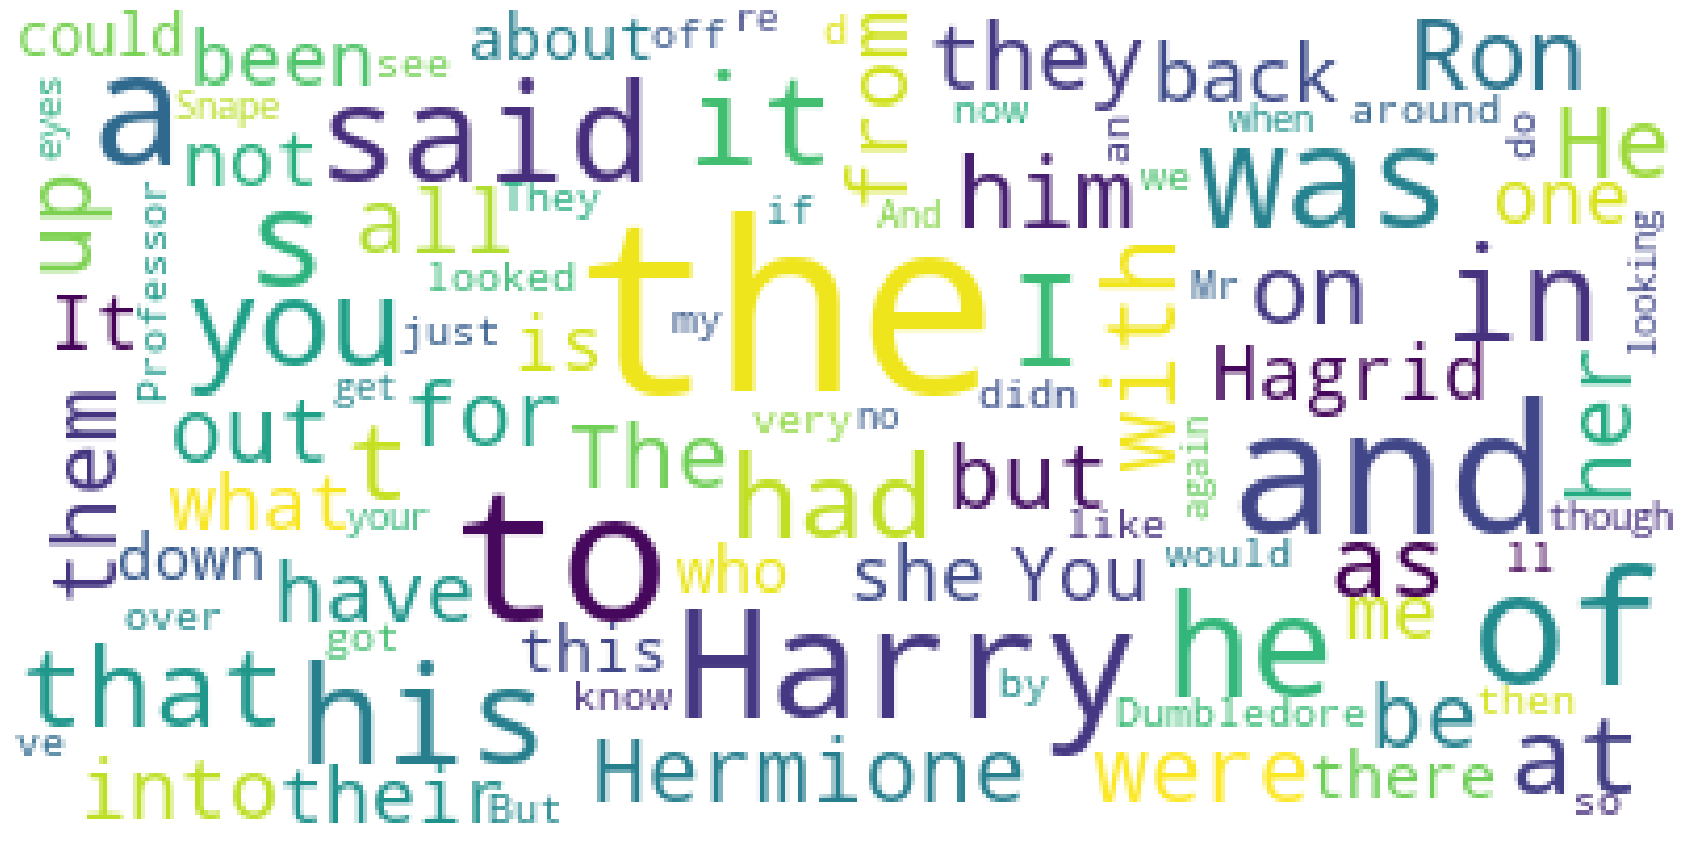

In [3]:
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt

twitter = Okt()

# twitter함수를 통해 읽어들인 내용의 형태소를 분석한다.
sentences_tag = []
sentences_tag = twitter.pos(harry_potter) 

noun_adj_list = []


# tag가 명사이거나 형용사인 단어들만 noun_adj_list에 넣어준다.
for word, tag in sentences_tag:
    if tag not in ['Punctuation']: 
        noun_adj_list.append(word)


# 가장 많이 나온 단어부터 100개를 저장한다.
counts = Counter(noun_adj_list)
tags = counts.most_common(100) 

print(tags)
# WordCloud를 생성한다.
# 한글이 없어서 별도로 나눔고딕을 사용하지는 않음
wc = WordCloud(background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(tags))

# 생성된 WordCloud를 test.jpg로 보낸다.

cloud.to_file('test.jpg')
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# word2vec 임베딩 벡터 산출
- https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b 으로부터 트레이닝 소스 받아서 사용
- 과제2에 사용한 데이터에 비해 자료양이 크므로 임베딩 벡터 사이즈를 500으로 늘리고 윈도우 사이즈로 15로 늘림


In [4]:
################################################################################
# folked from https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b  #
################################################################################

import numpy as np
import gensim
import string

from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file

print('\nPreparing the sentences...')

# 트레이닝 벡터의 사이즈에 따라 최대 문장 길이를 제한하고 대문자는 모두 소문자로 치환하여 word2vec 데이터 구성
max_sentence_len = 40
wData = word2vec.LineSentence("test.nlp")
sentences = [[word.lower() for word in w[:max_sentence_len] ] for w in wData] 

print('Num sentences:', len(sentences))

print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, size=500, min_count=1, window=15, iter=100)
pretrained_weights = word_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')

# 해리포터 등장인물에 대해 유사단어 검색
for word in ['vernon', 'harry', 'weasley', 'hermione']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

# 모델 저장
word_model.save("/content/drive/MyDrive/harry_potter/save_model/word2vec.model")
print("\Word2Vec Modeling finished")


Preparing the sentences...
Num sentences: 33309

Training word2vec...
Result embedding shape: (14037, 500)
Checking similar words:
  vernon -> bilius (0.40), aunt (0.38), faults (0.38), algie (0.35), dudley (0.33), meringue (0.33), incurably (0.29), dislodged (0.28)
  harry -> he (0.60), they (0.41), him (0.38), it (0.35), his (0.33), the (0.33), she (0.32), ron (0.29)
  weasley -> mason (0.60), straying (0.59), roberts (0.58), ridley (0.56), oblansk (0.55), obalonsk (0.54), borgin (0.52), ollivander (0.51)
  hermione -> she (0.34), parvati (0.33), ron (0.31), buckbeak (0.28), ginny (0.28), pansy (0.27), lavender (0.26), harry (0.26)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


\Word2Vec Modeling finished


# LSTM + Attention 트레이닝
- https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b 으로부터 트레이닝 소스 받아서 사용
- 매 epoch마다 테스트를 진행하는데 이 때 해리포터4의 마지막 문단에 나오는 문장들로 테스트를 진행하여 실제 원본 텍스트와 얼마나 차이나는지 확인

In [5]:
!pip install attention

In [6]:
################################################################################
# folked from https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b  #
################################################################################
from attention import Attention

import tensorflow as tf

tf.config.run_functions_eagerly(True)


def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences)], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence[:-1]):
    train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)

print('\nTraining Attention...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size, return_sequences=True))
model.add(Attention(emdedding_size/2))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def generate_next(text, num_generated=10):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
    'Uncle Vernon was waiting',
    'She hugged Harry',
    'Harry winked at them',
    'There was no point',
  ]
  for text in texts:
    sample = generate_next(text)
    print('%s... -> %s' % (text, sample))

model.fit(train_x, train_y,
          batch_size=128,
          epochs=100,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])


Preparing the data for LSTM...
train_x shape: (33309, 40)
train_y shape: (33309,)

Training LSTM...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
261/261 [==============================] - 156s 581ms/step - loss: 9.4869

Generating text after epoch: 0
Uncle Vernon was waiting... -> uncle vernon was waiting indignantly proceed gratitude even sickness sunshine windswept millions women unsuspecting
She hugged Harry... -> she hugged harry villager splintering trolls gathered wondrous itching crestfallen keep reverence unwisely
Harry winked at them... -> harry winked at them sludge behind expand benefited impressed sc drawback thunderbolt unleash adamant
There was no point... -> there was no point dungbomb jabbing display vein were maniac crowded powdered tiniest took
Epoch 2/100
261/261 [==============================] - 153s 587ms/step - loss: 9.2481

Generating text after epoch: 1
Uncle Vernon was waiting... -> uncle vernon was waiting tastes challenging pineapple portly blinking irresponsible state candlelight visitors arms
She hugged Harry... -> she hugged harry missed whirled sobs past tremulously screams pans forbi

ValueError: ignored

In [17]:
model.save("/content/drive/MyDrive/harry_potter/save_model/attention.model") 

ValueError: ignored

# 테스트
- 저장해둔 word2vec 임베딩 벡터와 Attention 모델을 불러옴
- generate_next() 함수안에 문장을 넣어 호출하면 이어지는 텍스트를 생성

In [9]:
from gensim.models import word2vec
from keras.models import load_model
import numpy as np

word_model = word2vec.Word2Vec.load("/content/drive/MyDrive/harry_potter/save_model/word2vec.model")
#model = load_model("/content/drive/MyDrive/harry_potter/save_model/test.model")

def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)


def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

def generate_next(text, num_generated=10):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
    'Uncle Vernon was waiting',
    'She hugged Harry',
    'Harry winked at them',
    'There was no point',
  ]
  for text in texts:
    sample = generate_next(text)
    print('%s... -> %s' % (text, sample))

In [13]:
# 테스트
tf.config.run_functions_eagerly(True)

print(generate_next("Uncle Vernon was waiting"))
print(generate_next("She hugged Harry"))
print(generate_next("Harry winked at them"))
print(generate_next("There was no point"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


uncle vernon was waiting out in grinned do table and as then spare the
she hugged harry the night he though harry champion up and that he
harry winked at them first class wand stop you face the okay door the
there was no point covered to of the ron here it a back me
